In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("loan_data_2007_2014.csv")
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [4]:
#drop unused column
df.drop(['policy_code',
         'url',
         'sub_grade',
         'title',
         'addr_state',
         'zip_code',
         'policy_code',
         'application_type',
         'emp_title','Unnamed: 0','id','member_id','desc','funded_amnt_inv'],axis=1,inplace=True)

In [5]:
total_null = df.isna().sum()
percent_missing = df.isna().sum() * 100 / len(df)
df_missing_value = pd.DataFrame({'total_null': total_null,
                                'percent_missing': percent_missing})
col_full_null = df_missing_value.loc[df_missing_value['percent_missing']> 50].index.tolist()
col_full_null

['mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [6]:
#drop missing value > 50%
df.drop(columns=col_full_null, inplace = True)

In [36]:
#check for duplicated Values
df.duplicated().sum()

0

In [7]:
#replacing null values with Median for Numerical column
for col in df.select_dtypes(exclude='object'):
    df[col] = df[col].fillna(df[col].median())

#replacing null values with Modus for Categorical column
for col in df.select_dtypes(include='object'):
    df[col] = df[col].fillna(df[col].mode().iloc[0])

df.isna().sum()

loan_amnt                     0
funded_amnt                   0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveri

In [8]:
#show unique values from each categorical column
def unqcol(data):
    for col in data.columns:
        x = data[col].unique()
        nunique = len(x)
        print(col," = ",nunique)
        print(col," = ",x)
        print("-"*30)
cat = df.select_dtypes(include='object')
unqcol(cat)

term  =  2
term  =  [' 36 months' ' 60 months']
------------------------------
grade  =  7
grade  =  ['B' 'C' 'A' 'E' 'F' 'D' 'G']
------------------------------
emp_length  =  11
emp_length  =  ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']
------------------------------
home_ownership  =  6
home_ownership  =  ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
------------------------------
verification_status  =  3
verification_status  =  ['Verified' 'Source Verified' 'Not Verified']
------------------------------
issue_d  =  91
issue_d  =  ['Dec-11' 'Nov-11' 'Oct-11' 'Sep-11' 'Aug-11' 'Jul-11' 'Jun-11' 'May-11'
 'Apr-11' 'Mar-11' 'Feb-11' 'Jan-11' 'Dec-10' 'Nov-10' 'Oct-10' 'Sep-10'
 'Aug-10' 'Jul-10' 'Jun-10' 'May-10' 'Apr-10' 'Mar-10' 'Feb-10' 'Jan-10'
 'Dec-09' 'Nov-09' 'Oct-09' 'Sep-09' 'Aug-09' 'Jul-09' 'Jun-09' 'May-09'
 'Apr-09' 'Mar-09' 'Feb-09' 'Jan-09' 'Dec-08' 'Nov-08' 'Oct-08' 'Sep-08'
 'Aug-08' 'Jul-08' 'Ju

last_credit_pull_d  =  103
last_credit_pull_d  =  ['Jan-16' 'Sep-13' 'Jan-15' 'Sep-15' 'Dec-14' 'Aug-12' 'Mar-13' 'Dec-15'
 'Aug-13' 'Nov-12' 'Mar-14' 'Apr-15' 'May-14' 'Jul-15' 'Jul-12' 'Sep-12'
 'May-13' 'Oct-15' 'Jun-12' 'Mar-15' 'Dec-12' 'Jul-14' 'Sep-14' 'Feb-14'
 'Jun-15' 'Oct-13' 'Apr-14' 'Oct-14' 'Feb-13' 'Nov-15' 'Oct-12' 'Nov-13'
 'Nov-14' 'Feb-12' 'Apr-12' 'Aug-15' 'Jun-14' 'Jan-12' 'Aug-14' 'Jun-13'
 'Dec-13' 'May-12' 'Jan-14' 'Jul-13' 'Apr-13' 'May-15' 'Feb-15' 'Mar-12'
 'Nov-11' 'Dec-11' 'Jan-13' 'Oct-11' 'Sep-11' 'Aug-11' 'Jul-11' 'Jun-11'
 'May-11' 'Apr-11' 'Mar-11' 'Feb-11' 'Jan-11' 'Dec-10' 'Nov-10' 'Oct-10'
 'Sep-10' 'Aug-10' 'Jul-10' 'Jun-10' 'May-10' 'Apr-10' 'Feb-10' 'Mar-10'
 'Aug-07' 'Jan-10' 'Dec-09' 'Nov-09' 'Oct-09' 'Sep-09' 'Jul-09' 'Aug-09'
 'Jun-09' 'May-09' 'Apr-09' 'Mar-09' 'Feb-09' 'Jan-09' 'Dec-08' 'Jun-08'
 'Sep-08' 'May-08' 'Aug-08' 'Mar-08' 'Oct-08' 'Feb-08' 'Jan-08' 'Dec-07'
 'Jul-08' 'Oct-07' 'Sep-07' 'Jun-07' 'May-07' 'Jul-07' 'Nov-07']
---------

In [20]:
purpose_n = df['purpose'].value_counts()
purpose_percentage = purpose_n / len(df) * 100
threshold = 5

df['purpose'] = df['purpose'].apply(lambda x: x if purpose_percentage[x] >= threshold else 'other')

In [10]:
home_n = df['home_ownership'].value_counts()
percentage = home_n / len(df) * 100
threshold = 7

df['home_ownership'] = df['home_ownership'].apply(lambda x: x if percentage[x] > threshold else 'OTHER')

In [11]:
bad_stats = ['Charged Off',
             'Late (31-120 days)',
             'Late (16-30 days)',
             'Default',
             'Does not meet the credit policy. Status:Charged Off']

df['bad_loan'] = np.where(df['loan_status'].isin(bad_stats),1,0)

In [12]:
bad_loan = df[df['bad_loan'] == 1]
good_loan = df[df['bad_loan'] == 0]

In [13]:
#change 'term' to numerical column
df['term'] = df['term'].apply(lambda term: int(term[:3]))

In [14]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['next_pymnt_d'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')

In [44]:
df[['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2011-12-01,1985-01-01,2015-01-01,2016-01-01
1,2011-12-01,1999-04-01,2013-04-01,2013-09-01
2,2011-12-01,2001-11-01,2014-06-01,2016-01-01
3,2011-12-01,1996-02-01,2015-01-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01,2016-01-01


In [15]:
#good loan = 0, bad loan = 1
df['bad_loan'].value_counts()

0    414099
1     52186
Name: bad_loan, dtype: int64

Text(0.5, 1.0, 'Loan Status')

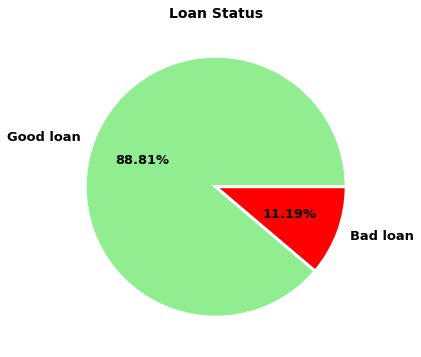

In [16]:
data = {'bad_loan': [0, 1],
        'total': [414099, 52186]}

temp = pd.DataFrame(data)

plt.figure(figsize=(6, 6))
colors = ["lightgreen", "red"]
labels = ['Good loan', 'Bad loan']
plt.pie(temp['total'], labels=labels, autopct='%.2f%%', colors=colors,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'fontsize': 13, 'fontweight': 'bold'})
plt.title('Loan Status', fontsize=14, fontweight='bold')

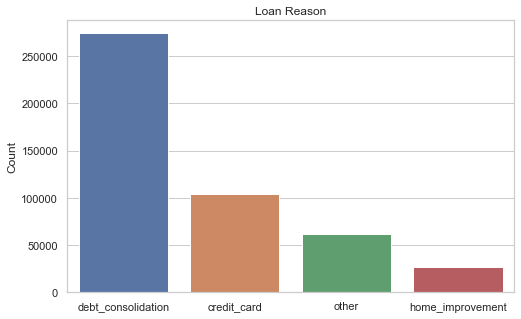

In [21]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=purpose_n.index, y=purpose_n.values)
ax.set_xticklabels(ax.get_xticklabels())
plt.title('Loan Reason')
plt.ylabel('Count')

plt.show()

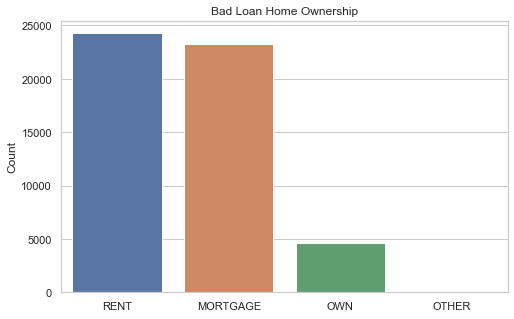

In [17]:
bad_home_n = bad_loan['home_ownership'].value_counts()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=bad_home_n.index, y=bad_home_n.values)
ax.set_xticklabels(ax.get_xticklabels())
plt.title('Bad Loan Home Ownership')
plt.ylabel('Count')

plt.show()

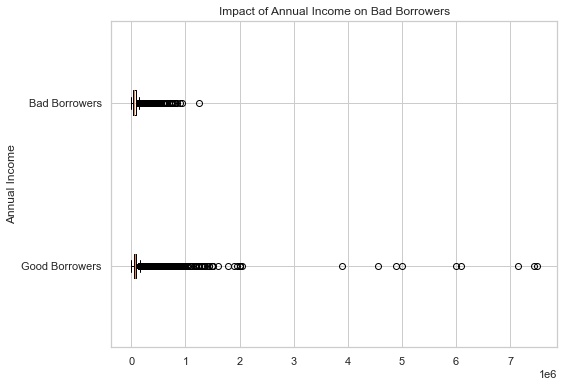

In [18]:
plt.figure(figsize=(8, 6))
plt.boxplot([good_loan['annual_inc'], bad_loan['annual_inc']], labels=['Good Borrowers', 'Bad Borrowers'],vert=False)
plt.title('Impact of Annual Income on Bad Borrowers')
plt.ylabel('Annual Income')
plt.show()

In [22]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highcorr_col = [column for column in upper.columns if any(upper[column] > 0.8)]

In [23]:
highcorr_col

['funded_amnt',
 'installment',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'collection_recovery_fee']

<AxesSubplot:>

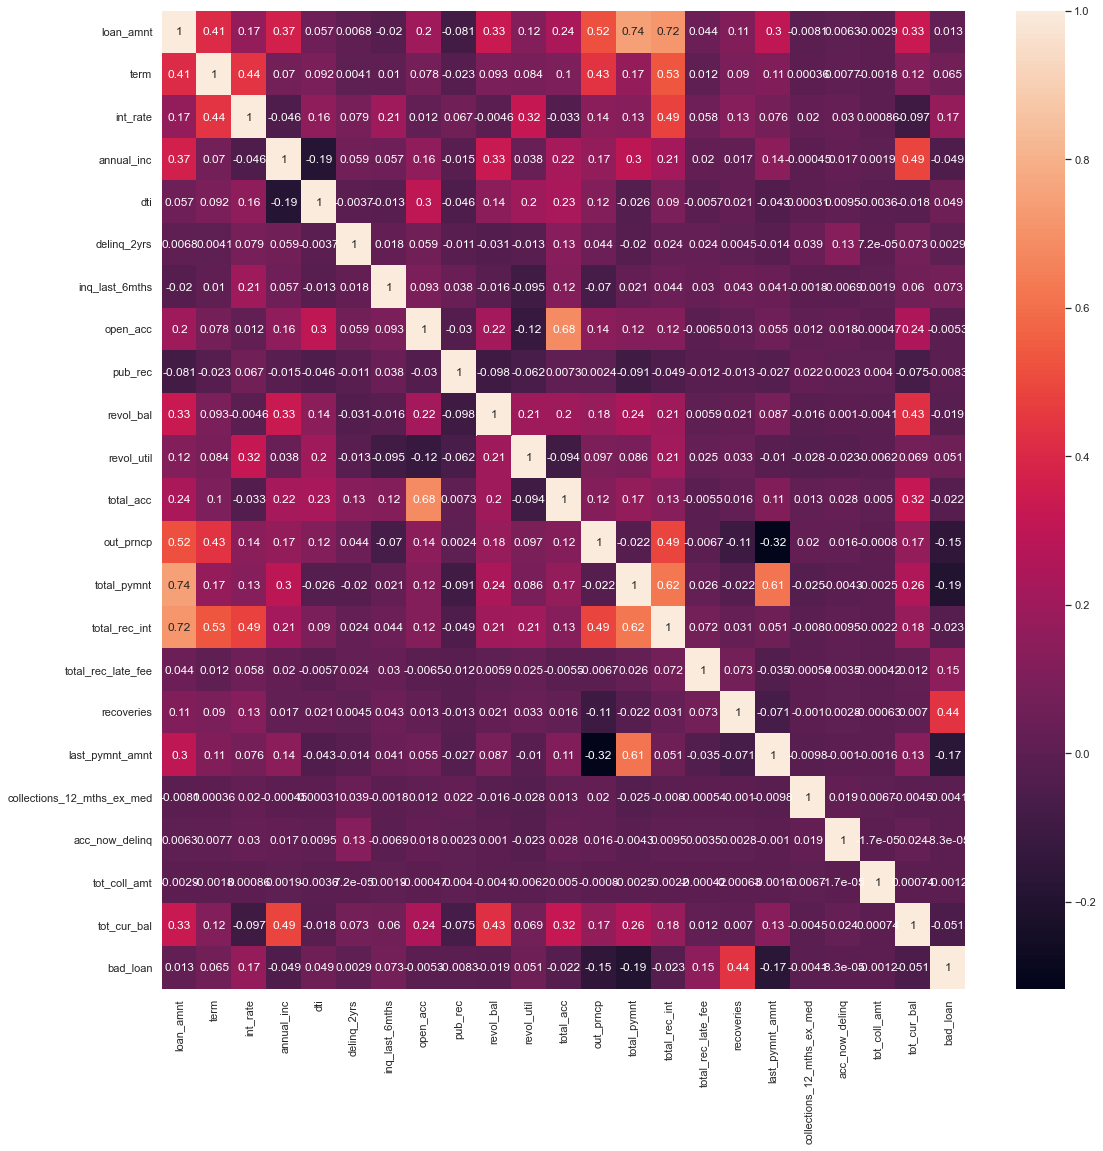

In [28]:
#drop High Correlation column (>80% correlation)
df.drop(highcorr_col, axis=1, inplace=True)

plt.figure(figsize=(18,18))
sns.heatmap(df.corr(),annot=True)

In [24]:
#ordinal-encoder
enc = OrdinalEncoder()
ordinal_cols = ['emp_length','loan_status','purpose']
df[ordinal_cols] = enc.fit_transform(df[ordinal_cols])

#one-hot-encoder
s = (df.dtypes == 'object')
cat = list(s[s].index)
onehots = pd.get_dummies(df[cat], drop_first=True)

In [25]:
df[['emp_length','loan_status','purpose']].head()

,emp_length,loan_status,purpose
0,1.0,5.0,0.0
1,10.0,0.0,3.0
2,1.0,5.0,3.0
3,1.0,5.0,3.0
4,0.0,1.0,3.0


In [26]:
onehots.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 13 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   grade_B                              466285 non-null  uint8
 1   grade_C                              466285 non-null  uint8
 2   grade_D                              466285 non-null  uint8
 3   grade_E                              466285 non-null  uint8
 4   grade_F                              466285 non-null  uint8
 5   grade_G                              466285 non-null  uint8
 6   home_ownership_OTHER                 466285 non-null  uint8
 7   home_ownership_OWN                   466285 non-null  uint8
 8   home_ownership_RENT                  466285 non-null  uint8
 9   verification_status_Source Verified  466285 non-null  uint8
 10  verification_status_Verified         466285 non-null  uint8
 11  pymnt_plan_y                         46

In [27]:
#standardization
numerical = df.select_dtypes(include='number').columns

scaler = StandardScaler()
std = pd.DataFrame(scaler.fit_transform(df[numerical]), columns=numerical)

In [28]:
final_data = pd.concat([onehots, std, df[['bad_loan']]], axis=1)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 47 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   grade_B                              466285 non-null  uint8  
 1   grade_C                              466285 non-null  uint8  
 2   grade_D                              466285 non-null  uint8  
 3   grade_E                              466285 non-null  uint8  
 4   grade_F                              466285 non-null  uint8  
 5   grade_G                              466285 non-null  uint8  
 6   home_ownership_OTHER                 466285 non-null  uint8  
 7   home_ownership_OWN                   466285 non-null  uint8  
 8   home_ownership_RENT                  466285 non-null  uint8  
 9   verification_status_Source Verified  466285 non-null  uint8  
 10  verification_status_Verified         466285 non-null  uint8  
 11  pymnt_plan_y 

In [29]:
X = final_data.drop(['bad_loan','loan_status'], axis=1)
y = final_data['bad_loan'].select_dtypes(exclude=['float64'])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((373028, 44), (93257, 44), (373028, 1), (93257, 1))

In [31]:
# Handle Imbalance Target Using SMOTE
sm = SMOTE(random_state=24)
sm.fit(X_train, y_train)
X_smote, y_smote = sm.fit_resample(X, y)
X_smote.shape, y_smote.shape

((828198, 44), (828198, 1))

In [32]:
# Spliting data to Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((662558, 44), (165640, 44), (662558, 1), (165640, 1))

In [33]:
# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# **Modeling**

In [34]:
#XGB Classifier
xgboost_model = XGBClassifier(random_state=1, use_label_encoder=False)
xgboost_model.fit(X_train, y_train)

[15:57:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [35]:
#Logistic Regression
model_logreg = LogisticRegression(solver='lbfgs', multi_class='auto')
model_logreg.fit(X_train,y_train)
y_pred = model_logreg.predict(X_test)

In [36]:
#Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train,y_train.values.ravel())
pred_rf = model_rf.predict(X_test)

In [37]:
models = [xgboost_model,model_logreg, model_rf]
accuracy_scores = []
for model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

print(accuracy_scores)

[0.8636561217097319, 0.9359273122434195, 0.96395798116397]


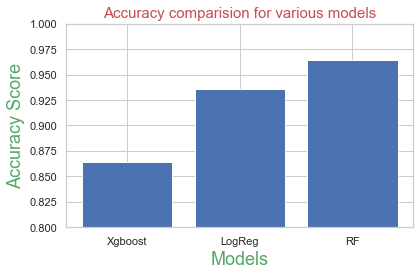

In [38]:
plt.bar(['Xgboost','LogReg','RF'],accuracy_scores)
plt.ylim(0.80,1.00)
plt.title('Accuracy comparision for various models', fontsize=15, color='r')
plt.xlabel('Models', fontsize=18, color='g')
plt.ylabel('Accuracy Score', fontsize=18, color='g')
plt.tight_layout()
plt.show()

In [39]:
#Random Forest Model
accuracy = accuracy_score(y_test, pred_rf)
precision = precision_score(y_test, pred_rf)
recall = recall_score(y_test, pred_rf)
f1 = f1_score(y_test, pred_rf)
confusion = confusion_matrix(y_test, pred_rf)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

print('Confusion Matrix:')
print(confusion)

Accuracy: 0.96
Precision: 1.00
Recall: 0.93
F1-score: 0.96
Confusion Matrix:
[[82488   201]
 [ 5769 77182]]
